## Load the Adult Data

In [1]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir_path = '/content/drive/MyDrive/CSE_248/'


In [3]:
!pip install torch folktables

In [4]:
!pip install torchattacks

In [5]:
import numpy as np
import torch
import torchattacks
from torch.utils.data import TensorDataset, DataLoader
from folktables import ACSDataSource, ACSEmployment, ACSIncome

Load the Adult dataset as numpy array.

In [6]:
data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(ca_data)

In [7]:
features

array([[36.,  1., 16., ..., 35.,  1.,  1.],
       [47.,  1., 20., ..., 60.,  2.,  1.],
       [20.,  1., 19., ..., 40.,  1.,  1.],
       ...,
       [40.,  1., 21., ..., 30.,  2.,  1.],
       [40.,  3., 20., ..., 56.,  1.,  1.],
       [19.,  1., 18., ..., 12.,  2.,  1.]])

In [8]:
label

array([False, False, False, ..., False,  True, False])

Load the numpy array as torch tensors.

In [9]:
print(features.shape, label.shape , group)
label = label.astype(int)
print(label)
import torchvision
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

transforms=torchvision.transforms.Normalize(mean=mean, std=std)
print(mean, std)
# torchvision.transforms.Normalize(
#       [, meanOfChannel2, meanOfChannel3] 
#     , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
# )

(183941, 10) (183941,) [1 1 1 ... 1 1 1]
[0 0 0 ... 0 1 0]
[4.25959955e+01 2.13534775e+00 1.82591157e+01 2.59421227e+00
 4.09451381e+03 9.85371396e+01 2.39410463e+00 3.75533459e+01
 1.46659527e+00 2.94694494e+00] [1.45125584e+01 1.87004811e+00 4.03001797e+00 1.82616454e+00
 2.55685362e+03 1.25330860e+02 4.35867541e+00 1.30693068e+01
 4.98882876e-01 2.85988350e+00]


In [10]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data).float(), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data).float(), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



The training data has the size of 147152 and the val has the size of 36789


In [11]:
import torch.nn as nn

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=10, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = output.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor, mean, std):
    return ((tensor - mean) / std).float()

In [12]:
LR = 0.1
NUM_EPOCH = 10
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(normalization(train_sample, mean=mean, std=std))
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = our_net(normalization(val_sample, mean=mean, std=std))
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/1150: loss is 0.763647
Epoch 0 Current Step 200/1150: loss is 0.455790
Epoch 0 Current Step 400/1150: loss is 0.461641
Epoch 0 Current Step 600/1150: loss is 0.411248
Epoch 0 Current Step 800/1150: loss is 0.418187
Epoch 0 Current Step 1000/1150: loss is 0.463880
------------------------------------------------
Epoch 0 Validation acc is 0.805823
Epoch 1 Current Step 0/1150: loss is 0.454192
Epoch 1 Current Step 200/1150: loss is 0.369133
Epoch 1 Current Step 400/1150: loss is 0.382942
Epoch 1 Current Step 600/1150: loss is 0.336638
Epoch 1 Current Step 800/1150: loss is 0.382894
Epoch 1 Current Step 1000/1150: loss is 0.434134
------------------------------------------------
Epoch 1 Validation acc is 0.806028
Epoch 2 Current Step 0/1150: loss is 0.347986
Epoch 2 Current Step 200/1150: loss is 0.425866
Epoch 2 Current Step 400/1150: loss is 0.386132
Epoch 2 Current Step 600/1150: loss is 0.441618
Epoch 2 Current Step 800/1150: loss is 0.521740
Epoch 2 Current Step

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


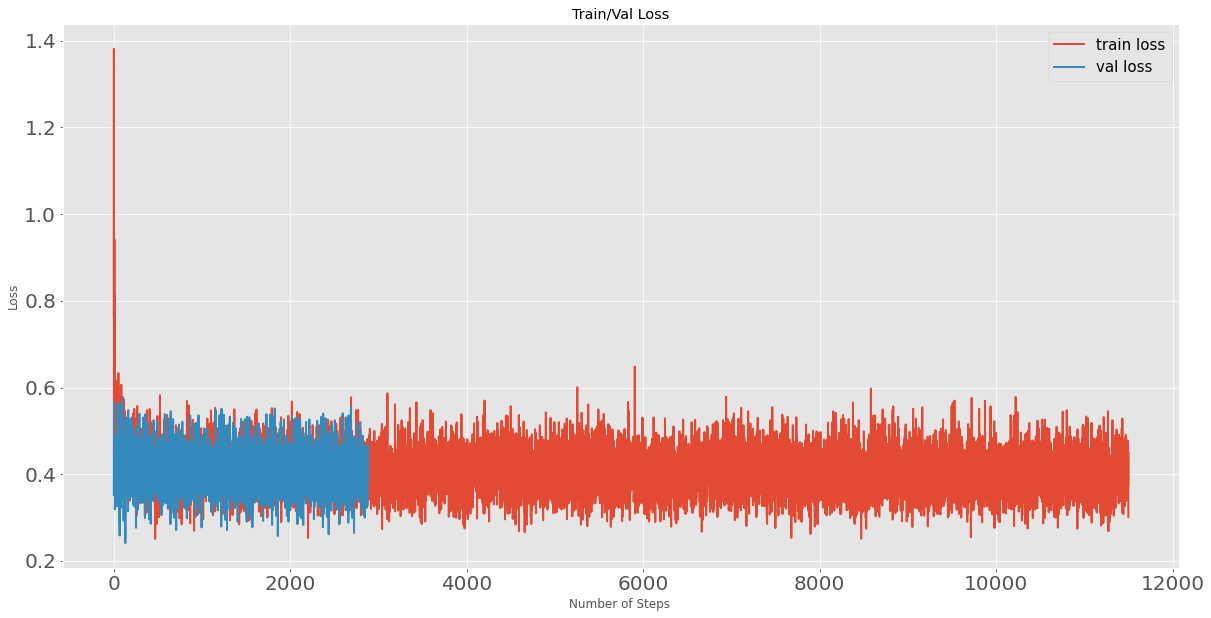

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

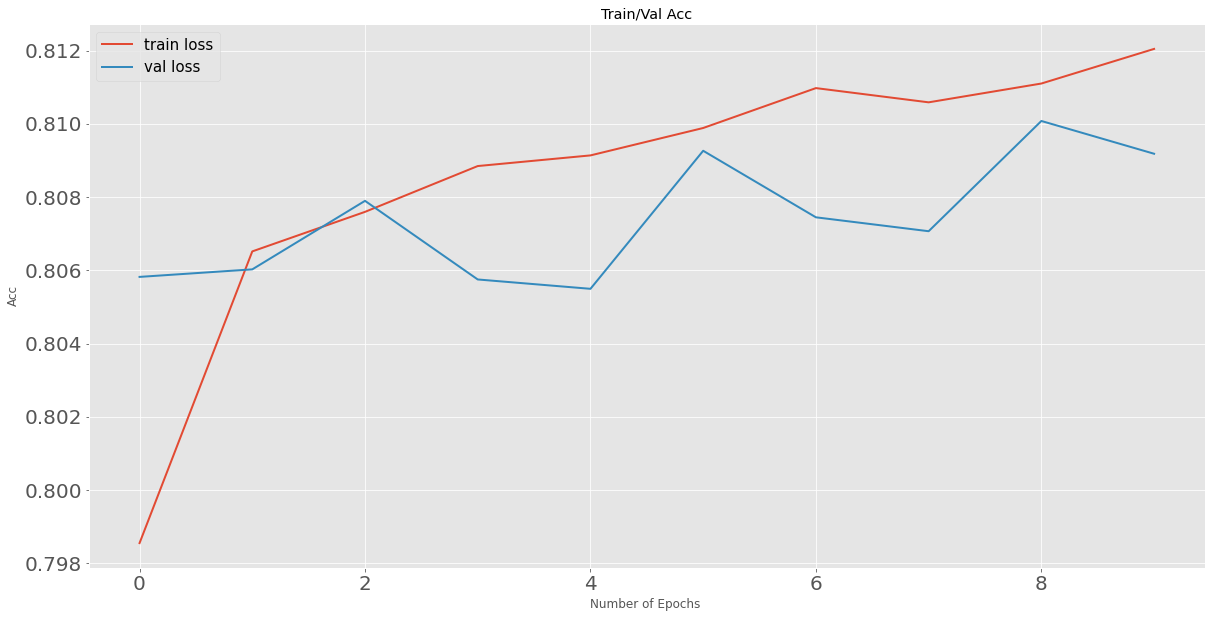

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [15]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



The training data has the size of 147152 and the val has the size of 36789


In [16]:
import torch.nn as nn

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=10, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = outputs.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor, mean, std):
    return tensor - mean / std

In [20]:
LR = 0.1
NUM_EPOCH = 10
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(normalization(train_sample, mean=mean, std=std).float())
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = our_net(normalization(val_sample, mean=mean, std=std).float())
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/1150: loss is 0.948429
Epoch 0 Current Step 200/1150: loss is 0.594099
Epoch 0 Current Step 400/1150: loss is 0.521051
Epoch 0 Current Step 600/1150: loss is 0.552674
Epoch 0 Current Step 800/1150: loss is 0.659366
Epoch 0 Current Step 1000/1150: loss is 0.537127
------------------------------------------------
Epoch 0 Validation acc is 0.717148
Epoch 1 Current Step 0/1150: loss is 0.641398
Epoch 1 Current Step 200/1150: loss is 0.491093
Epoch 1 Current Step 400/1150: loss is 0.651751
Epoch 1 Current Step 600/1150: loss is 0.530660
Epoch 1 Current Step 800/1150: loss is 0.566948
Epoch 1 Current Step 1000/1150: loss is 0.561883
------------------------------------------------
Epoch 1 Validation acc is 0.743097
Epoch 2 Current Step 0/1150: loss is 0.574553
Epoch 2 Current Step 200/1150: loss is 0.544038
Epoch 2 Current Step 400/1150: loss is 0.601851
Epoch 2 Current Step 600/1150: loss is 0.535606
Epoch 2 Current Step 800/1150: loss is 0.500500
Epoch 2 Current Step

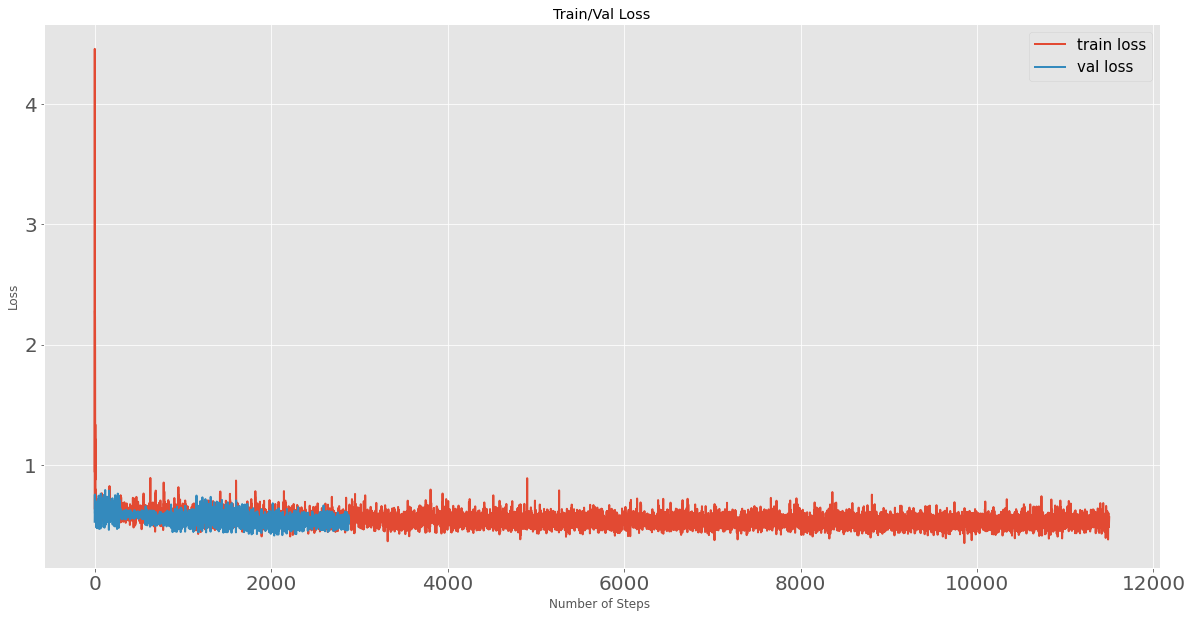

In [21]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

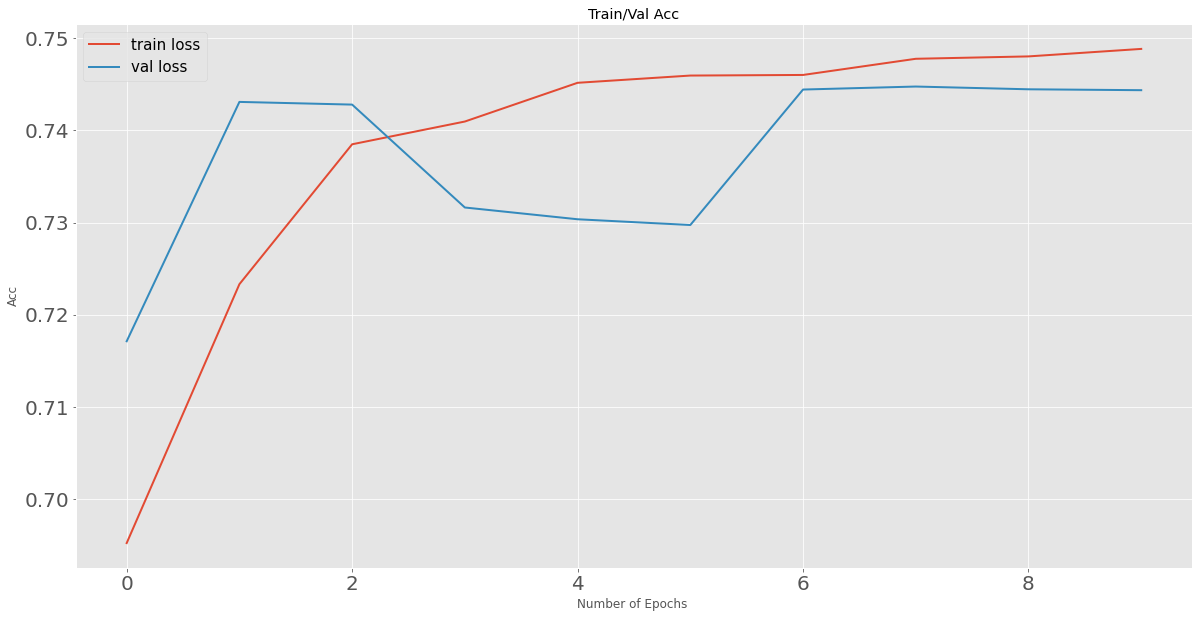

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [23]:
torch.save(our_net.state_dict(), dir_path+'naturally_trained_model.pt')

# Adversarial Training Procedure


In [ ]:
num_wrong = 0
num_attempt = 0
for batch_id, (train_sample, train_labels) in enumerate(train_loader):
    if batch_id > 10:
      break
    for j in range(train_sample.shape[0]):
        instance = train_sample[j]
        label = train_labels[j]

        attacker = torchattacks.PGD(our_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker(normalization(instance, mean=mean, std=std), label.long())

        model_guess = our_net(normalization(instance, mean=mean, std=std)).max(0).indices
        adv_guess = our_net(normalization(adv_image, mean=mean, std=std)).max(0).indices
        if model_guess !=  adv_guess:
            num_wrong += 1
        num_attempt += 1
print('Number Incorrect: {}'.format(num_wrong))
print('Number Attempted: {}'.format(num_attempt))

In [ ]:
import copy 

LR = 0.01
NUM_EPOCH = 10
LOG_STEP = 200

adv_net = copy.deepcopy(our_net)
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(adv_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

attacker = torchattacks.PGD(adv_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
for epoch in range(NUM_EPOCH):
    adv_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader): 
        train_labels = train_labels.long()
        # Generate adv. examples to mix in 
        atk_inds = np.random.choice(range(train_sample.shape[0]), size=train_sample.shape[0]//2, replace=False)
        orig_inds = [ind for ind in range(train_sample.shape[0]) if ind not in atk_inds]
        adv_samples = attacker(normalization(train_sample[atk_inds], mean=mean, std=std).float(), train_labels[atk_inds])
        orig_samples = train_sample[orig_inds]
        mixed_set = torch.cat((adv_samples, orig_samples))
        mixed_labels = torch.cat((train_labels[atk_inds], train_labels[orig_inds]))
        
        output = adv_net(normalization(mixed_set, mean=mean, std=std).float())
        loss = criterion(output, mixed_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    adv_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = adv_net(normalization(val_sample, mean=mean, std=std).float())
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))

Epoch 0 Current Step 0/1150: loss is 1.111663
Epoch 0 Current Step 200/1150: loss is 0.598759
Epoch 0 Current Step 400/1150: loss is 0.574351
Epoch 0 Current Step 600/1150: loss is 0.573619
Epoch 0 Current Step 800/1150: loss is 0.520460
Epoch 0 Current Step 1000/1150: loss is 0.536308
------------------------------------------------
Epoch 0 Validation acc is 0.743499
Epoch 1 Current Step 0/1150: loss is 0.551652
Epoch 1 Current Step 200/1150: loss is 0.582314
Epoch 1 Current Step 400/1150: loss is 0.574014
Epoch 1 Current Step 600/1150: loss is 0.622020
Epoch 1 Current Step 800/1150: loss is 0.559263
Epoch 1 Current Step 1000/1150: loss is 0.615536
------------------------------------------------
Epoch 1 Validation acc is 0.743836
Epoch 2 Current Step 0/1150: loss is 0.587325
Epoch 2 Current Step 200/1150: loss is 0.655090
Epoch 2 Current Step 400/1150: loss is 0.572148
Epoch 2 Current Step 600/1150: loss is 0.560137
Epoch 2 Current Step 800/1150: loss is 0.580918
Epoch 2 Current Step

In [ ]:
plot_loss_fig(train_all_loss, val_all_loss)

In [ ]:
plot_acc_fig(train_acc, val_acc)

In [ ]:
num_wrong_nat = 0
num_attempt_nat = 0
num_wrong_adv = 0
num_attempt_adv = 0
for batch_id, (train_sample, train_labels) in enumerate(train_loader):
    if batch_id > 10:
      break
    for j in range(train_sample.shape[0]):
        instance = train_sample[j]
        label = train_labels[j]

        attacker_nat = torchattacks.PGD(our_net, eps=8/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_nat(normalization(instance, mean=mean, std=std).float(), label.long())
        model_guess_nat = our_net(normalization(instance, mean=mean, std=std).float()).max(0).indices
        adv_guess_nat = our_net(normalization(adv_image, mean=mean, std=std).float()).max(0).indices
        if model_guess_nat !=  adv_guess_nat:
            num_wrong_nat += 1
        num_attempt_nat += 1

        attacker_adv = torchattacks.PGD(adv_net, eps=8/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_adv(normalization(instance, mean=mean, std=std).float(), label.long())
        model_guess_adv = adv_net(normalization(instance, mean=mean, std=std).float()).max(0).indices
        adv_guess_adv = adv_net(normalization(adv_image, mean=mean, std=std).float()).max(0).indices
        if model_guess_adv !=  adv_guess_adv:
            num_wrong_adv += 1
        num_attempt_adv += 1

print('Number Incorrect (natural model): {}'.format(num_wrong_nat))
print('Number Attempted (natural model): {}'.format(num_attempt_nat))

print('Number Incorrect (adversarially trained model): {}'.format(num_wrong_adv))
print('Number Attempted (adversarially trained model): {}'.format(num_attempt_adv))

In [ ]:
torch.save(adv_net.state_dict(), dir_path+'adversarially_trained_model.pt')

# Recourse Generation


In [ ]:
! pip install carla-recourse

In [ ]:
data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(ca_data)

In [3]:
features = ['AGEP','COW','SCHL','MAR','OCCP','POBP','RELP','WKHP','SEX','RAC1P']

features = ['Age', 
            'Worker_Type', 
            'Education_Level', 
            'Marital_Status', 
            'Occupation_Code', 
            'State', 
            'Relationship', 
            'Hours_Per_Week', 
            'Sex', 
            'Race',
            'Income_Greater_50k'
            ]

NameError: ignored

In [ ]:
from carla import Data

# Custom data set implementations need to inherit from the Data interface
class IncomeDataset(Data):
    def __init__(self, data):
        # The data set can e.g. be loaded in the constructor
        self._dataset = data

    # List of all categorical features
    @property
    def categorical(self):
        return ['Worker_Type','Marital_Status', 'Occupation_Code', 'State', 'Relationship', 'Sex','Race']

    # List of all continuous features
    @property
    def continuous(self):
        return ['Age', 'Education_Level', 'Hours_Per_Week']

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return ['Sex','Race', 'State']

    # Feature name of the target column
    @property
    def target(self):
        return 'Income_Greater_50k'

    # Non-encoded and  non-normalized, raw data set
    @property
    def raw(self):
        return self._dataset

id = IncomeDataset

In [2]:
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import GrowingSpheres

# load a catalog dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

dataset.raw

# # load artificial neural network from catalog
# model = MLModelCatalog(dataset, "ann")

# # get factuals from the data to generate counterfactual examples
# factuals = dataset.raw.iloc[:10]

# # load a recourse model and pass black box model
# gs = GrowingSpheres(model)

# # generate counterfactual examples
# counterfactuals = gs.get_counterfactuals(factuals)


NameError: ignored

In [ ]:
factuals = 
gs = GrowingSpheres(our_net)

# generate counterfactual examples
counterfactuals = gs.get_counterfactuals(factuals)